<a href="https://colab.research.google.com/github/danglive/Optimization-tutorial/blob/master/Tensorflow_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import izip_longest
from functools import partial

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

import tensorflow as tf
import numpy as np

In [2]:
def f_p(x, y):
    return (x**2 + y**2) + (0.5*x + y)**2 + (0.5*x + y)**4

minima = np.array([0, 0])
start_point = np.array([8, 8])
minima_ = minima.reshape(-1, 1)

xmin, xmax = -10, 10
ymin, ymax = -10, 10

print f_p(*minima)


X = np.arange(xmin, xmax, 0.25)
Y = np.arange(ymin, ymax, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f_p(X, Y)

# Beale's function
x = tf.Variable(8., trainable=True)
y = tf.Variable(8., trainable=True)

f = tf.add_n([
    
    tf.add(tf.square(x), tf.square(y)), 
    tf.square(tf.add(tf.multiply(0.5, x), y)), 
    tf.pow(tf.multiply(0.5, x), 4.)
    
])

# f = tf.add_n([tf.square(tf.add(tf.subtract(1.5, x), tf.multiply(x, y))),
#           tf.square(tf.add(tf.subtract(2.25, x), tf.multiply(x, tf.square(y)))),
#           tf.square(tf.add(tf.subtract(2.625, x), tf.multiply(x, tf.pow(y, 3))))])

0.0


In [0]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in izip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [0]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in izip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [5]:
opt = tf.train.MomentumOptimizer(0.01, 0.9)
grads_and_vars = opt.compute_gradients(f, [x, y])
clipped_grads_and_vars = [(tf.clip_by_value(g, xmin, xmax), v) for g, v in grads_and_vars]

train = opt.apply_gradients(clipped_grads_and_vars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

points_tf = []
for i in range(100):
    points_tf.append(sess.run([x, y]))
    sess.run(train)

W1019 21:42:47.987977 139981141436288 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
opt = tf.train.GradientDescentOptimizer(0.01)
grads_and_vars = opt.compute_gradients(f, [x, y])
clipped_grads_and_vars = [(tf.clip_by_value(g, xmin, xmax), v) for g, v in grads_and_vars]

train = opt.apply_gradients(clipped_grads_and_vars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

points_tf2 = []
for i in range(100):
    points_tf2.append(sess.run([x, y]))
    sess.run(train)

In [0]:
opt = tf.train.AdamOptimizer(1)
grads_and_vars = opt.compute_gradients(f, [x, y])
clipped_grads_and_vars = [(tf.clip_by_value(g, xmin, xmax), v) for g, v in grads_and_vars]

train = opt.apply_gradients(clipped_grads_and_vars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

points_tf3 = []
for i in range(100):
    points_tf3.append(sess.run([x, y]))
    sess.run(train)

In [8]:
opt = tf.train.RMSPropOptimizer(1)
grads_and_vars = opt.compute_gradients(f, [x, y])
clipped_grads_and_vars = [(tf.clip_by_value(g, xmin, xmax), v) for g, v in grads_and_vars]

train = opt.apply_gradients(clipped_grads_and_vars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

points_tf4 = []
for i in range(100):
    points_tf4.append(sess.run([x, y]))
    sess.run(train)

W1019 21:42:48.953788 139981141436288 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/training/rmsprop.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
methods = ['Momentum Gradient Descent', 'Gradient Descent', 'Adam', 'RMSProp']

paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(start_point)
    
paths = [np.array(points_tf).T, np.array(points_tf2).T, np.array(points_tf3).T, np.array(points_tf4).T]

f = f_p

zpaths = [f(*path) for path in paths]

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


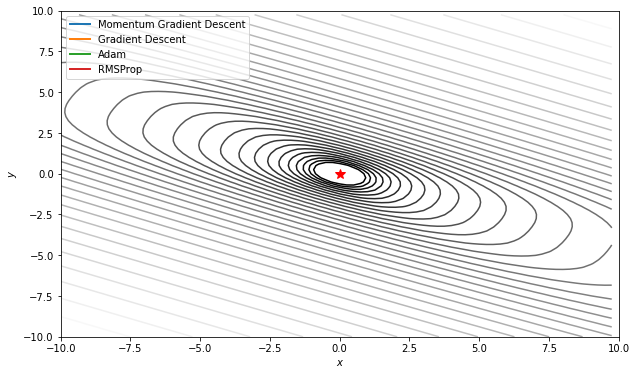

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=cm.gray)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(paths, labels=methods, ax=ax)

ax.legend(loc='upper left')


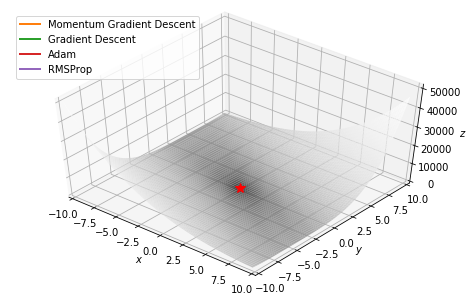

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=cm.gray)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')
